# RSNA Intracranial Hemorrhage Detection 

<b>Competition Overview</b><br/><br/>
Intracranial hemorrhage, bleeding that occurs inside the cranium, is a serious health problem requiring rapid and often intensive medical treatment. For example, intracranial hemorrhages account for approximately 10% of strokes in the U.S., where stroke is the fifth-leading cause of death. Identifying the location and type of any hemorrhage present is a critical step in treating the patient.

Diagnosis requires an urgent procedure. When a patient shows acute neurological symptoms such as severe headache or loss of consciousness, highly trained specialists review medical images of the patient’s cranium to look for the presence, location and type of hemorrhage. The process is complicated and often time consuming.

<b>What am i predicting?</b><br/><br/>
In this competition our goal is to predict intracranial hemorrhage and its subtypes. Given an image the we need to predict probablity of each subtype. This indicates its a multilabel classification problem.

<b>Competition Evaluation Metric</b><br/><br/>
Evaluation metric is weighted multi-label logarithmic loss. So for given image we need to predict probality for each subtype. There is also an any label, which indicates that a hemorrhage of ANY kind exists in the image. The any label is weighted more highly than specific hemorrhage sub-types.

<b>Note:</b>The weights for each subtype for calculating weighted multi-label logarithmic loss is **not** given as part of the competition. We will be using binary cross entropy loss as weights are not available

<b>Dataset Description</b>

The dataset is divided into two parts

1. Train
2. Test

**1. Train**
Number of rows: 40,45,548 records.
Number of columns: 2

Columns:

**Id**: An image Id. Each Id corresponds to a unique image, and will contain an underscore.

Example: ID_28fbab7eb_epidural. So the Id consists of two parts one is image file id ID_28fbab7eb and the other is sub type name

**Label**: The target label whether that sub-type of hemorrhage (or any hemorrhage in the case of any) exists in the indicated image. 1 --> Exists and 0 --> Doesn't exist.

**2. Test**
Number of rows: 4,71,270 records.

Columns:

**Id**: An image Id. Each Id corresponds to a unique image, and will contain an underscore.

Example: ID_28fbab7eb_epidural. So the Id consists of two parts one is image file id ID_28fbab7eb and the other is sub type name

In [1]:
import numpy as np
import pandas as pd
import pydicom
import os
import glob
import random
import cv2
import tensorflow as tf
from math import ceil, floor
from tqdm import tqdm
from imgaug import augmenters as iaa
import matplotlib.pyplot as plt
from math import ceil, floor
import keras
import keras.backend as K
from keras.callbacks import Callback, ModelCheckpoint
from keras.layers import Dense, Flatten, Dropout
from keras.models import Model, load_model
from keras.utils import Sequence
from keras.losses import binary_crossentropy
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
# Random Seed
SEED = 42
np.random.seed(SEED)

# some constants
TEST_SIZE = 0.06
HEIGHT = 256
WIDTH = 256
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 64

# Train and Test folders
input_folder = '../input/rsna-intracranial-hemorrhage-detection/'
path_train_img = input_folder + 'stage_1_train_images/'
path_test_img = input_folder + 'stage_1_test_images/'

In [3]:
train_df = pd.read_csv(input_folder + 'stage_1_train.csv')
train_df.head()

,ID,Label
0,ID_63eb1e259_epidural,0
1,ID_63eb1e259_intraparenchymal,0
2,ID_63eb1e259_intraventricular,0
3,ID_63eb1e259_subarachnoid,0
4,ID_63eb1e259_subdural,0


In [4]:
# extract subtype
train_df['sub_type'] = train_df['ID'].apply(lambda x: x.split('_')[-1])
# extract filename
train_df['file_name'] = train_df['ID'].apply(lambda x: '_'.join(x.split('_')[:2]) + '.dcm')
train_df.head()

,ID,Label,sub_type,file_name
0,ID_63eb1e259_epidural,0,epidural,ID_63eb1e259.dcm
1,ID_63eb1e259_intraparenchymal,0,intraparenchymal,ID_63eb1e259.dcm
2,ID_63eb1e259_intraventricular,0,intraventricular,ID_63eb1e259.dcm
3,ID_63eb1e259_subarachnoid,0,subarachnoid,ID_63eb1e259.dcm
4,ID_63eb1e259_subdural,0,subdural,ID_63eb1e259.dcm


In [5]:
train_df.shape

(4045572, 4)

In [6]:
# remove duplicates
train_df.drop_duplicates(['Label', 'sub_type', 'file_name'], inplace=True)
train_df.shape

(4045548, 4)

In [7]:
print("Number of train images availabe:", len(os.listdir(path_train_img)))

Number of train images availabe: 674258


In [8]:
train_final_df = pd.pivot_table(train_df.drop(columns='ID'), index="file_name", \
                                columns="sub_type", values="Label")
train_final_df.head()

sub_type,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
file_name,,,,,,
ID_000039fa0.dcm,0,0,0,0,0,0
ID_00005679d.dcm,0,0,0,0,0,0
ID_00008ce3c.dcm,0,0,0,0,0,0
ID_0000950d7.dcm,0,0,0,0,0,0
ID_0000aee4b.dcm,0,0,0,0,0,0


In [9]:
train_final_df.shape

(674258, 6)

In [10]:
# Invalid image ID_6431af929.dcm
train_final_df.drop('ID_6431af929.dcm', inplace=True)

In [11]:
# Install Efficient Net as it is not part of Keras
!pip install efficientnet
!pip install iterative-stratification

In [12]:
import efficientnet.keras as efn 
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

In [13]:
from IPython.display import HTML

def create_download_link(title = "Download CSV file", filename = "data.csv"):  
    """
    Helper function to generate download link to files in kaggle kernel 
    """
    html = '<a href={filename}>{title}</a>'
    html = html.format(title=title,filename=filename)
    return HTML(html)

In [14]:
def get_dicom_field_value(val):
    """
    Helper function to get value of dicom field in dicom file
    """
    if type(val) == pydicom.multival.MultiValue:
        return int(val[0])
    else:
        return int(val)

def get_windowing(data):
    """
    Helper function to extract meta data features in dicom file
    return: window center, window width, slope, intercept
    """
    dicom_fields = [data.WindowCenter, data.WindowWidth, data.RescaleSlope, data.RescaleIntercept]
    return [get_dicom_field_value(x) for x in dicom_fields]


def get_windowed_image(image, wc, ww, slope, intercept):
    """
    Helper function to construct windowed image from meta data features
    return: windowed image
    """
    img = (image*slope +intercept)
    img_min = wc - ww//2
    img_max = wc + ww//2
    img[img<img_min] = img_min
    img[img>img_max] = img_max
    return img 


def _normalize(img):
    if img.max() == img.min():
        return np.zeros(img.shape)
    return 2 * (img - img.min())/(img.max() - img.min()) - 1

def _read(path, desired_size=(224, 224)):
    """
    Helper function to generate windowed image 
    """
    # 1. read dicom file
    dcm = pydicom.dcmread(path)
    
    # 2. Extract meta data features
    # window center, window width, slope, intercept
    window_params = get_windowing(dcm)

    try:
        # 3. Generate windowed image
        img = get_windowed_image(dcm.pixel_array, *window_params)
    except:
        img = np.zeros(desired_size)

    img = _normalize(img)

    if desired_size != (512, 512):
        # resize image
        img = cv2.resize(img, desired_size, interpolation = cv2.INTER_LINEAR)
    return img[:,:,np.newaxis]

In [15]:
_read(path_train_img + 'ID_ffff922b9.dcm', (128, 128)).shape

(128, 128, 1)

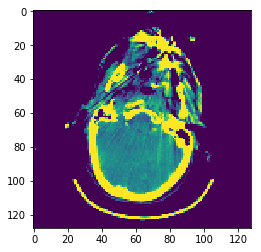

In [16]:
plt.imshow(
    _read(path_train_img + 'ID_ffff922b9.dcm', (128, 128))[:, :, 0]
)

In [17]:
# Augmentations
# Flip Left Right
# Cropping
sometimes = lambda aug: iaa.Sometimes(0.25, aug)
augmentation = iaa.Sequential([  
                                iaa.Fliplr(0.25),
                                sometimes(iaa.Crop(px=(0, 25), keep_size = True, 
                                                   sample_independently = False))   
                            ], random_order = True)

In [18]:
# Train Data Generator
class TrainDataGenerator(keras.utils.Sequence):

    def __init__(self, dataset, labels, batch_size=16, img_size=(512, 512), img_dir = path_train_img, \
                 augment = False, *args, **kwargs):
        self.dataset = dataset
        self.ids = dataset.index
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.img_dir = img_dir
        self.augment = augment
        self.on_epoch_end()

    def __len__(self):
        return int(ceil(len(self.ids) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        X, Y = self.__data_generation(indices)
        return X, Y

    def augmentor(self, image):
        augment_img = augmentation        
        image_aug = augment_img.augment_image(image)
        return image_aug

    def on_epoch_end(self):
        self.indices = np.arange(len(self.ids))
        np.random.shuffle(self.indices)
        
    def __data_generation(self, indices):
        X = np.empty((self.batch_size, *self.img_size, 3))
        Y = np.empty((self.batch_size, 6), dtype=np.float32)
        
        for i, index in enumerate(indices):
            ID = self.ids[index]
            image = _read(self.img_dir + ID, self.img_size)
            if self.augment:
                X[i,] = self.augmentor(image)
            else:
                X[i,] = image            
            Y[i,] = self.labels.iloc[index].values        
        return X, Y
    
class TestDataGenerator(keras.utils.Sequence):
    def __init__(self, ids, labels, batch_size = 5, img_size = (512, 512), img_dir = path_test_img, \
                 *args, **kwargs):
        self.ids = ids
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.img_dir = img_dir
        self.on_epoch_end()

    def __len__(self):
        return int(ceil(len(self.ids) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.ids[k] for k in indices]
        X = self.__data_generation(list_IDs_temp)
        return X

    def on_epoch_end(self):
        self.indices = np.arange(len(self.ids))

    def __data_generation(self, list_IDs_temp):
        X = np.empty((self.batch_size, *self.img_size, 3))
        for i, ID in enumerate(list_IDs_temp):
            image = _read(self.img_dir + ID, self.img_size)
            X[i,] = image            
        return X

As we have seen in EDA notebook that we have very few epidural subtypes so we need oversample this sub type

In [19]:
# Oversampling
epidural_df = train_final_df[train_final_df.epidural == 1]
train_final_df = pd.concat([train_final_df, epidural_df])
print('Train Shape: {}'.format(train_final_df.shape))

Train Shape: (677018, 6)


In [20]:
# load test set
test_df = pd.read_csv(input_folder + 'stage_1_sample_submission.csv')
test_df.head()

,ID,Label
0,ID_28fbab7eb_epidural,0.5
1,ID_28fbab7eb_intraparenchymal,0.5
2,ID_28fbab7eb_intraventricular,0.5
3,ID_28fbab7eb_subarachnoid,0.5
4,ID_28fbab7eb_subdural,0.5


In [21]:
# extract subtype
test_df['sub_type'] = test_df['ID'].apply(lambda x: x.split('_')[-1])
# extract filename
test_df['file_name'] = test_df['ID'].apply(lambda x: '_'.join(x.split('_')[:2]) + '.dcm')

test_df = pd.pivot_table(test_df.drop(columns='ID'), index="file_name", \
                                columns="sub_type", values="Label")
test_df.head()

test_df.shape

(78545, 6)

In [22]:
test_df.head()

sub_type,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
file_name,,,,,,
ID_000012eaf.dcm,0.5,0.5,0.5,0.5,0.5,0.5
ID_0000ca2f6.dcm,0.5,0.5,0.5,0.5,0.5,0.5
ID_000259ccf.dcm,0.5,0.5,0.5,0.5,0.5,0.5
ID_0002d438a.dcm,0.5,0.5,0.5,0.5,0.5,0.5
ID_00032d440.dcm,0.5,0.5,0.5,0.5,0.5,0.5


In [23]:
base_model =  efn.EfficientNetB0(weights = 'imagenet', include_top = False, \
                                 pooling = 'avg', input_shape = (HEIGHT, WIDTH, 3))
x = base_model.output
x = Dropout(0.125)(x)
output_layer = Dense(6, activation = 'sigmoid')(x)
model = Model(inputs=base_model.input, outputs=output_layer)
model.compile(optimizer = Adam(learning_rate = 0.0001), 
                  loss = 'binary_crossentropy',
                  metrics = ['acc', tf.keras.metrics.AUC()])
model.summary()

16809984/16804768 [==============================] - 1s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 128, 128, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 128, 128, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 128, 128, 32) 0           stem_bn[0][0]                    
___________________________

In [25]:
# https://github.com/trent-b/iterative-stratification
# Mutlilabel stratification
splits = MultilabelStratifiedShuffleSplit(n_splits = 2, test_size = TEST_SIZE, random_state = SEED)
file_names = train_final_df.index
labels = train_final_df.values
# Lets take only the first split
split = next(splits.split(file_names, labels))
train_idx = split[0]
valid_idx = split[1]
submission_predictions = []
len(train_idx), len(valid_idx)

(636396, 40622)

In [26]:
# train data generator
data_generator_train = TrainDataGenerator(train_final_df.iloc[train_idx], 
                                                train_final_df.iloc[train_idx], 
                                                TRAIN_BATCH_SIZE, 
                                                (WIDTH, HEIGHT),
                                                augment = True)

# validation data generator
data_generator_val = TrainDataGenerator(train_final_df.iloc[valid_idx], 
                                            train_final_df.iloc[valid_idx], 
                                            VALID_BATCH_SIZE, 
                                            (WIDTH, HEIGHT),
                                            augment = False)

In [27]:
len(data_generator_train), len(data_generator_val)

(19888, 635)

Competition evaluation metric is evaluated based on weighted log loss but we haven't given weights for each subtype but as per discussion from this thread https://www.kaggle.com/c/rsna-intracranial-hemorrhage-detection/discussion/109526#latest-630190 any has a wieght of 2 than other types below sample is taken from the discussion threas

In [28]:
from keras import backend as K

def weighted_log_loss(y_true, y_pred):
    """
    Can be used as the loss function in model.compile()
    ---------------------------------------------------
    """
    
    class_weights = np.array([2., 1., 1., 1., 1., 1.])
    
    eps = K.epsilon()
    
    y_pred = K.clip(y_pred, eps, 1.0-eps)

    out = -(         y_true  * K.log(      y_pred) * class_weights
            + (1.0 - y_true) * K.log(1.0 - y_pred) * class_weights)
    
    return K.mean(out, axis=-1)


def _normalized_weighted_average(arr, weights=None):
    """
    A simple Keras implementation that mimics that of 
    numpy.average(), specifically for this competition
    """
    
    if weights is not None:
        scl = K.sum(weights)
        weights = K.expand_dims(weights, axis=1)
        return K.sum(K.dot(arr, weights), axis=1) / scl
    return K.mean(arr, axis=1)


def weighted_loss(y_true, y_pred):
    """
    Will be used as the metric in model.compile()
    ---------------------------------------------
    
    Similar to the custom loss function 'weighted_log_loss()' above
    but with normalized weights, which should be very similar 
    to the official competition metric:
        https://www.kaggle.com/kambarakun/lb-probe-weights-n-of-positives-scoring
    and hence:
        sklearn.metrics.log_loss with sample weights
    """
    
    class_weights = K.variable([2., 1., 1., 1., 1., 1.])
    
    eps = K.epsilon()
    
    y_pred = K.clip(y_pred, eps, 1.0-eps)

    loss = -(        y_true  * K.log(      y_pred)
            + (1.0 - y_true) * K.log(1.0 - y_pred))
    
    loss_samples = _normalized_weighted_average(loss, class_weights)
    
    return K.mean(loss_samples)


def weighted_log_loss_metric(trues, preds):
    """
    Will be used to calculate the log loss 
    of the validation set in PredictionCheckpoint()
    ------------------------------------------
    """
    class_weights = [2., 1., 1., 1., 1., 1.]
    
    epsilon = 1e-7
    
    preds = np.clip(preds, epsilon, 1-epsilon)
    loss = trues * np.log(preds) + (1 - trues) * np.log(1 - preds)
    loss_samples = np.average(loss, axis=1, weights=class_weights)

    return - loss_samples.mean()

In [29]:
filepath="model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, \
                             save_best_only=True, mode='min')

callbacks_list = [checkpoint]

For a single epoch we are going to train only last 5 layers of Efficient. Since we have a large number of images around 600k so its better to train the all the layers on the whole train dataset but due its high computation resources required to train we only goin to train last five layers on whole dataset and for rest of epochs we only train on a sample of dataset but will train all the layers.

In [31]:
train = False

In [32]:
if train:
    if not os.path.isfile('../input/orginal-087-eff/model.h5'):
        for layer in model.layers[:-5]:
            layer.trainable = False
        model.compile(optimizer = Adam(learning_rate = 0.0001), 
                      loss = 'binary_crossentropy',
                      metrics = ['acc'])

        model.fit_generator(generator = data_generator_train,
                            validation_data = data_generator_val,
                            epochs = 2,
                            callbacks = callbacks_list,
                            verbose = 1)

In [33]:
if train:
    for base_layer in model.layers[:-1]:
        base_layer.trainable = True

    model.load_weights('model.h5')

    model.compile(optimizer = Adam(learning_rate = 0.0004), 
                      loss = 'binary_crossentropy',
                      metrics = ['acc'])
    model.fit_generator(generator = data_generator_train,
                            validation_data = data_generator_val,
                            steps_per_epoch=len(data_generator_train)/6,
                            epochs = 10,
                            callbacks = callbacks_list,
                            verbose = 1)

In [34]:
!pip install gdown

  Created wheel for gdown: filename=gdown-3.8.3-cp36-none-any.whl size=8850 sha256=ca7bf131547dd1503032ee6ec7567ff06fb7ddad8d44a32f00f874aadbd01a5e
  Stored in directory: /tmp/.cache/pip/wheels/a7/9d/16/9e0bda9a327ff2cddaee8de48a27553fb1efce73133593d066
Successfully built gdown


In [35]:
!gdown https://drive.google.com/uc?id=1kZmMCCBOWSjCZjz2XWaouDIj5gFn2D-q

Downloading...
From: https://drive.google.com/uc?id=1kZmMCCBOWSjCZjz2XWaouDIj5gFn2D-q
To: /kaggle/working/model (4).h5
49.2MB [00:03, 14.6MB/s]


In [36]:
!cp "model (4).h5" model.h5

In [37]:
model.load_weights('model.h5')

preds = model.predict_generator(TestDataGenerator(test_df.index, None, VALID_BATCH_SIZE, \
                                                  (WIDTH, HEIGHT), path_test_img), 
                                verbose=1)
preds.shape

1228/1228 [==============================] - 856s 697ms/step


(78592, 6)

In [38]:
from tqdm import tqdm

In [39]:
cols = list(train_final_df.columns)

In [40]:
# We have preditions for each of the image
# We need to make 6 rows for each of file according to the subtype
ids = []
values = []
for i, j in tqdm(zip(preds, test_df.index.to_list()), total=preds.shape[0]):
#     print(i, j)
    # i=[any_prob, epidural_prob, intraparenchymal_prob, intraventricular_prob, subarachnoid_prob, subdural_prob]
    # j = filename ==> ID_xyz.dcm
    for k in range(i.shape[0]):
        ids.append([j.replace('.dcm', '_' + cols[k])])
        values.append(i[k])      

100%|█████████▉| 78545/78592 [00:01<00:00, 51807.96it/s]


In [41]:
df = pd.DataFrame(data=ids)
df.head()

,0
0,ID_000012eaf_any
1,ID_000012eaf_epidural
2,ID_000012eaf_intraparenchymal
3,ID_000012eaf_intraventricular
4,ID_000012eaf_subarachnoid


In [42]:
sample_df = pd.read_csv(input_folder + 'stage_1_sample_submission.csv')
sample_df.head()

,ID,Label
0,ID_28fbab7eb_epidural,0.5
1,ID_28fbab7eb_intraparenchymal,0.5
2,ID_28fbab7eb_intraventricular,0.5
3,ID_28fbab7eb_subarachnoid,0.5
4,ID_28fbab7eb_subdural,0.5


In [43]:
df['Label'] = values
df.columns = sample_df.columns
df.head()

,ID,Label
0,ID_000012eaf_any,0.008506
1,ID_000012eaf_epidural,0.000114
2,ID_000012eaf_intraparenchymal,0.001682
3,ID_000012eaf_intraventricular,0.000329
4,ID_000012eaf_subarachnoid,0.000926


In [44]:
df.to_csv('submission.csv', index=False)

In [45]:
create_download_link(filename='submission.csv')